<a href="https://colab.research.google.com/github/gweakliem/colab-notebooks/blob/main/Fine_Tune_gemma_3_270m_to_play_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from a [tweet by ashkay_pachaar](https://x.com/akshay_pachaar/status/1956334618715800005)

In [1]:
!pip install unsloth til

In [2]:
from unsloth import FastLanguageModel
import torch
MODEL = "unsloth/gemma-3-270m-it"
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = MODEL,
  max_seq_length = 2048,
  dtype = None,
  load_in_4bit = False,
  full_finetuning = False
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.6: Fast Gemma3 patching. Transformers: 4.55.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


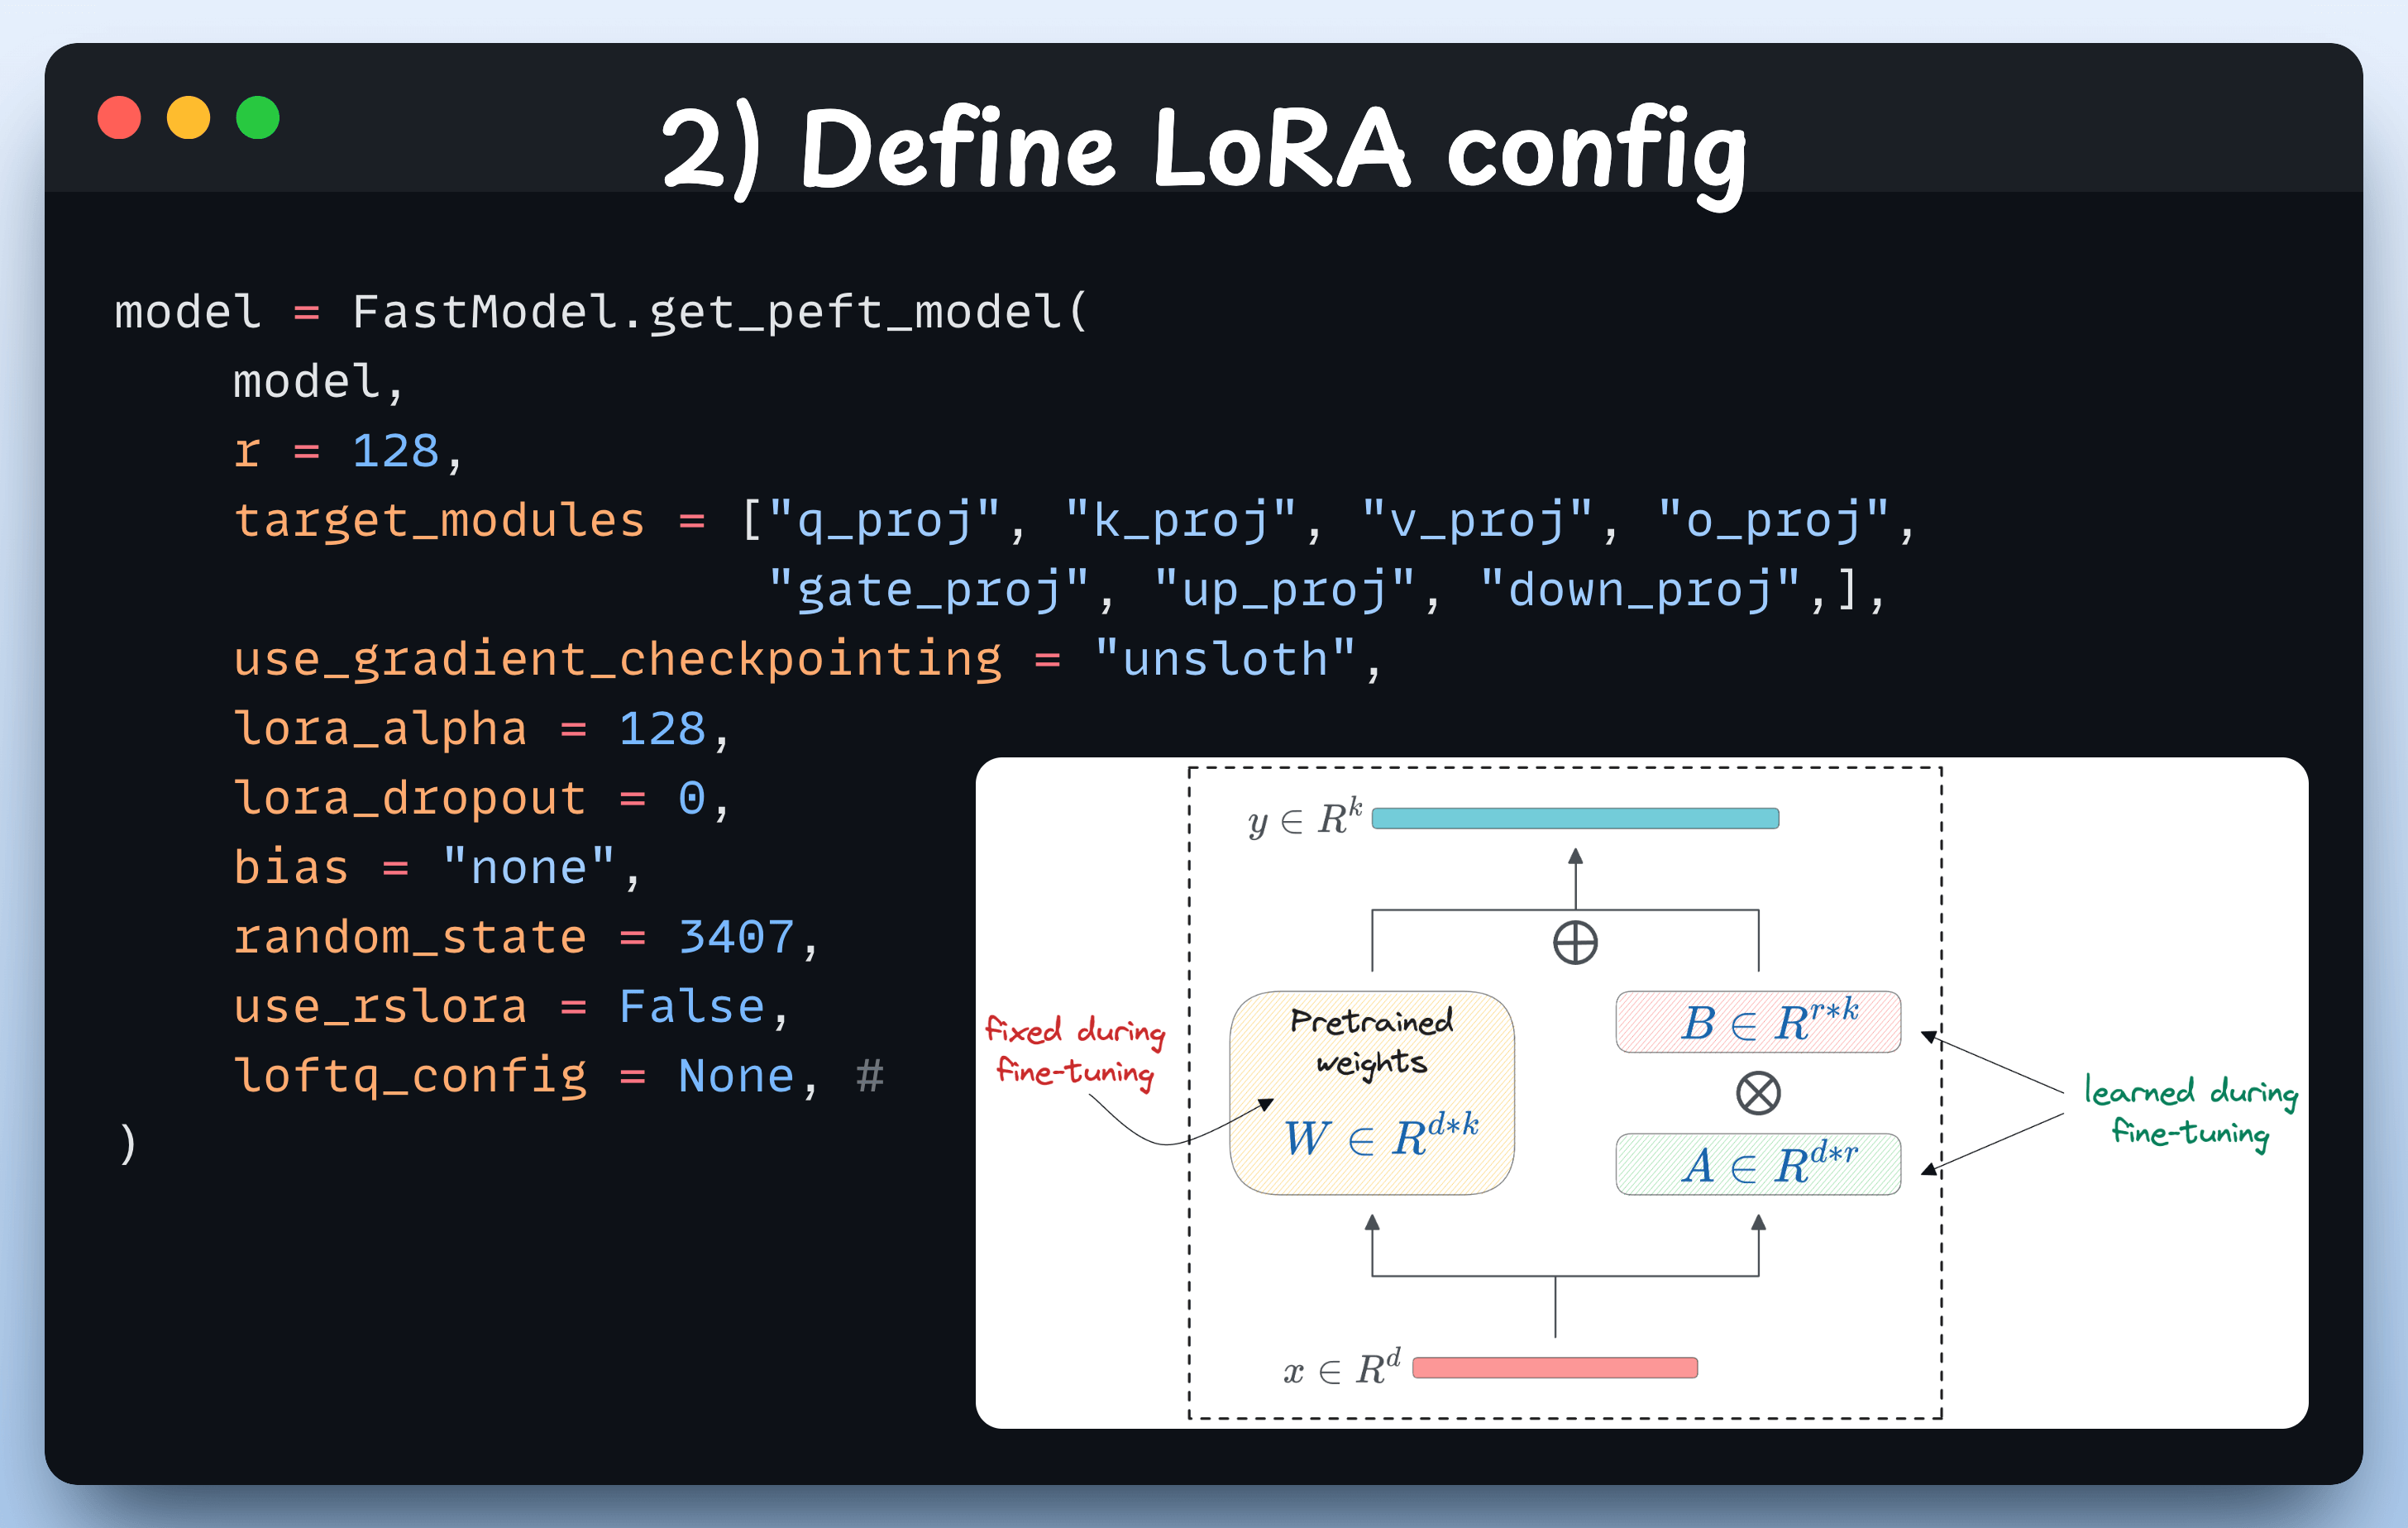

In [7]:
model = FastLanguageModel.get_peft_model(
  model,
  I = 128,
  target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
  "gate-proj", "up_proj", "down_proj", ],
  use_gradient_checkpointing = "unsloth",
  lora_alpha = 128,
  lora_dropout = 0,
  bias = "none",
  random_state = 3407,
  use_Islora = False,
  loftq_config = None
)

Unsloth: Making `model.base_model.model.model` require gradients


In [8]:
from datasets import load_dataset
dataset_name = "Thytu/ChessInstruct"
dataset = load_dataset(dataset_name, split = "train[:10000]")
dataset[0]

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/161M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'task': "Given an incomplit set of chess moves and the game's final score, write the last missing chess move.\n\nInput Format: A comma-separated list of chess moves followed by the game score.\nOutput Format: The missing chess move",
 'input': '{"moves": ["d2d4", "g8f6", "c2c4", "e7e6", "b1c3", "f8b4", "d1c2", "d7d5", "a2a3", "b4c3", "c2c3", "f6e4", "c3c2", "e8g8", "g1f3", "b7b6", "c1f4", "c7c5", "e2e3", "c8b7", "d4c5", "b6c5", "e1c1", "b8c6", "f1d3", "d8b6", "d3e4", "d5e4", "f3e5", "c6e5", "f4e5", "f7f6", "e5c3", "a8d8", "d1d8", "f8d8", "c2a4", "b7c6", "a4a5", "g8f7", "c1c2", "e6e5", "b2b3", "d8d7", "a5b6", "a7b6", "a3a4", "d7a7", "h1a1", "f7e7", "a4a5", "b6a5", "c3a5", "e7e6", "c2b2", "h7h5", "a1a3", "a7a6", "a5c7", "c6b7", "a3a5", "a6a5", "c7a5", "e6d6", "b3b4", "c5b4", "a5b4", "d6d7", "b2c3", "b7c8", "b4f8", "g7g6", "c3b4", "h5h4", "b4b5", "c8b7", "f8g7", "f6f5", "g7e5", "b7c6", "b5c5", "h4h3", "g2h3", "c6a8", "e5d6", "a8c6", "d6f8", "c6b7", "c5d4", "d7e6", "h3h4", "b7c6", "f8h6",

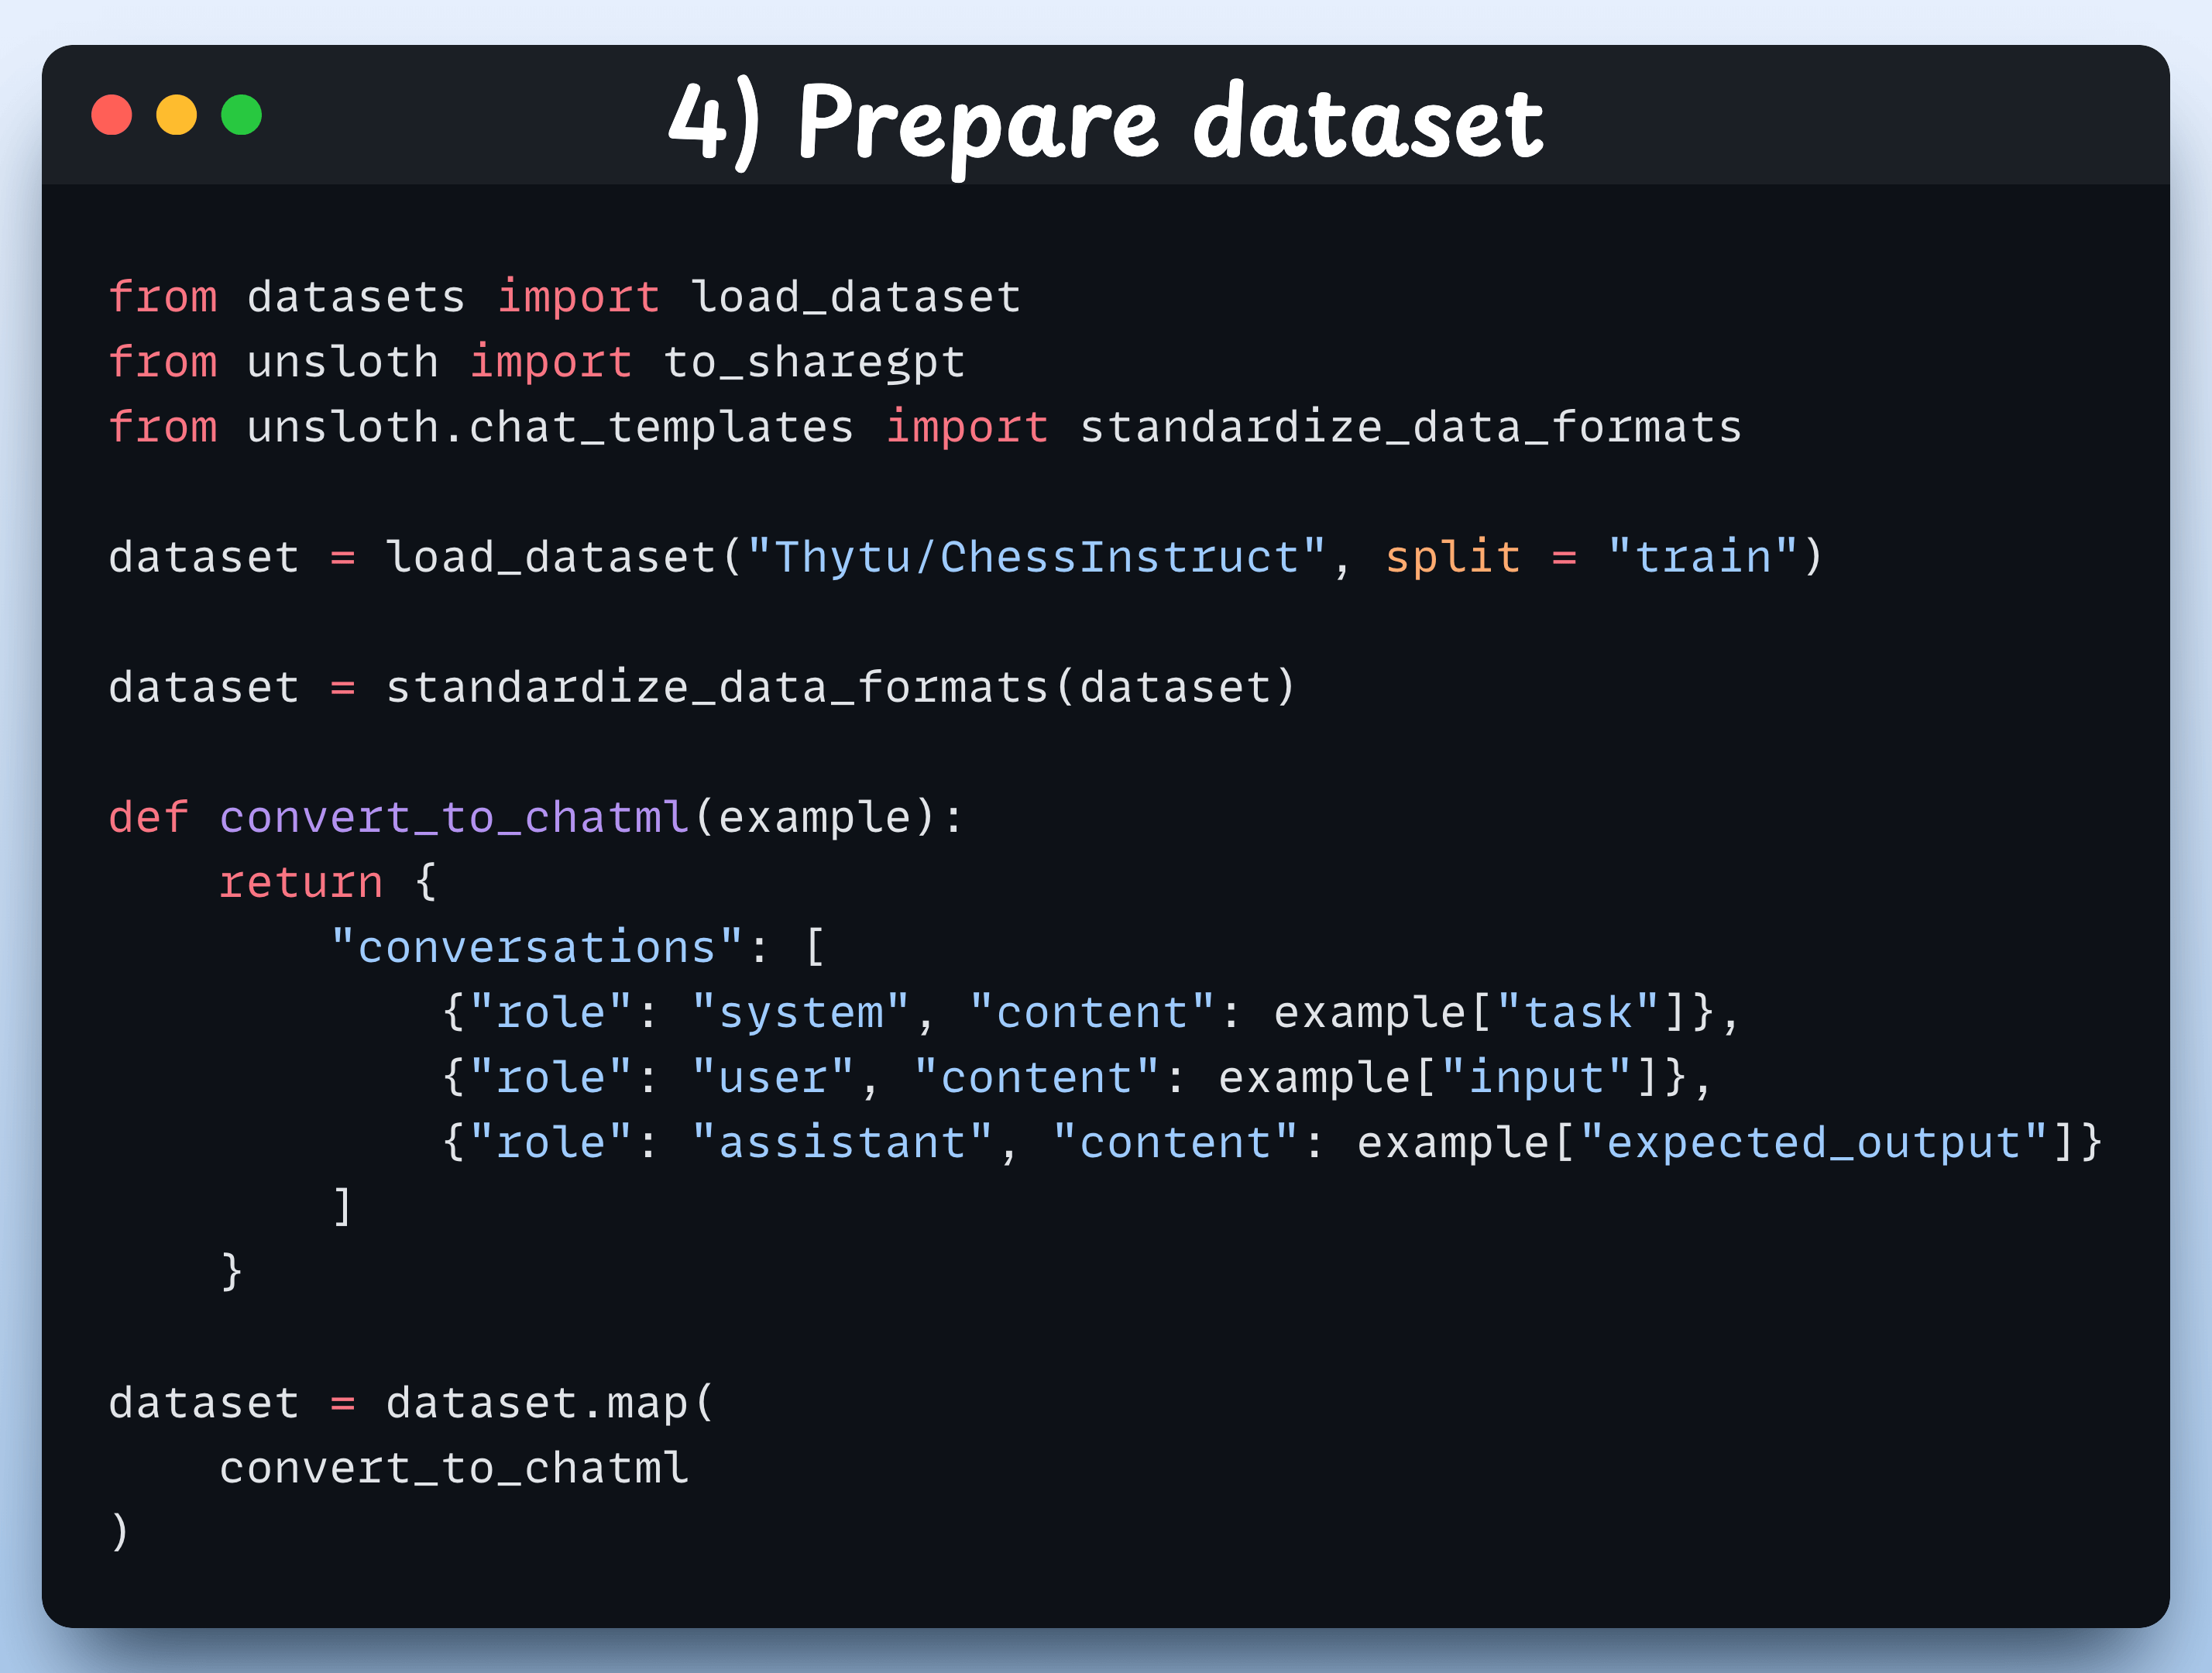

In [9]:
from datasets import load_dataset
from unsloth import to_sharegpt
from unsloth.chat_templates import standardize_data_formats
dataset = load_dataset ("Thytu/ChessInstruct", split = "train")
dataset = standardize_data_formats (dataset)
def convert_to_chatml (example):
  return {
    "conversations": [
        {"role": "system", "content": example["task"]},
        {"role": "user", "content": example["input"]},
        {"role": "assistant", "content": example["expected_output"]}
    ]
  }
dataset = dataset.map (
  convert_to_chatml
)

Map:   0%|          | 0/99000 [00:00<?, ? examples/s]

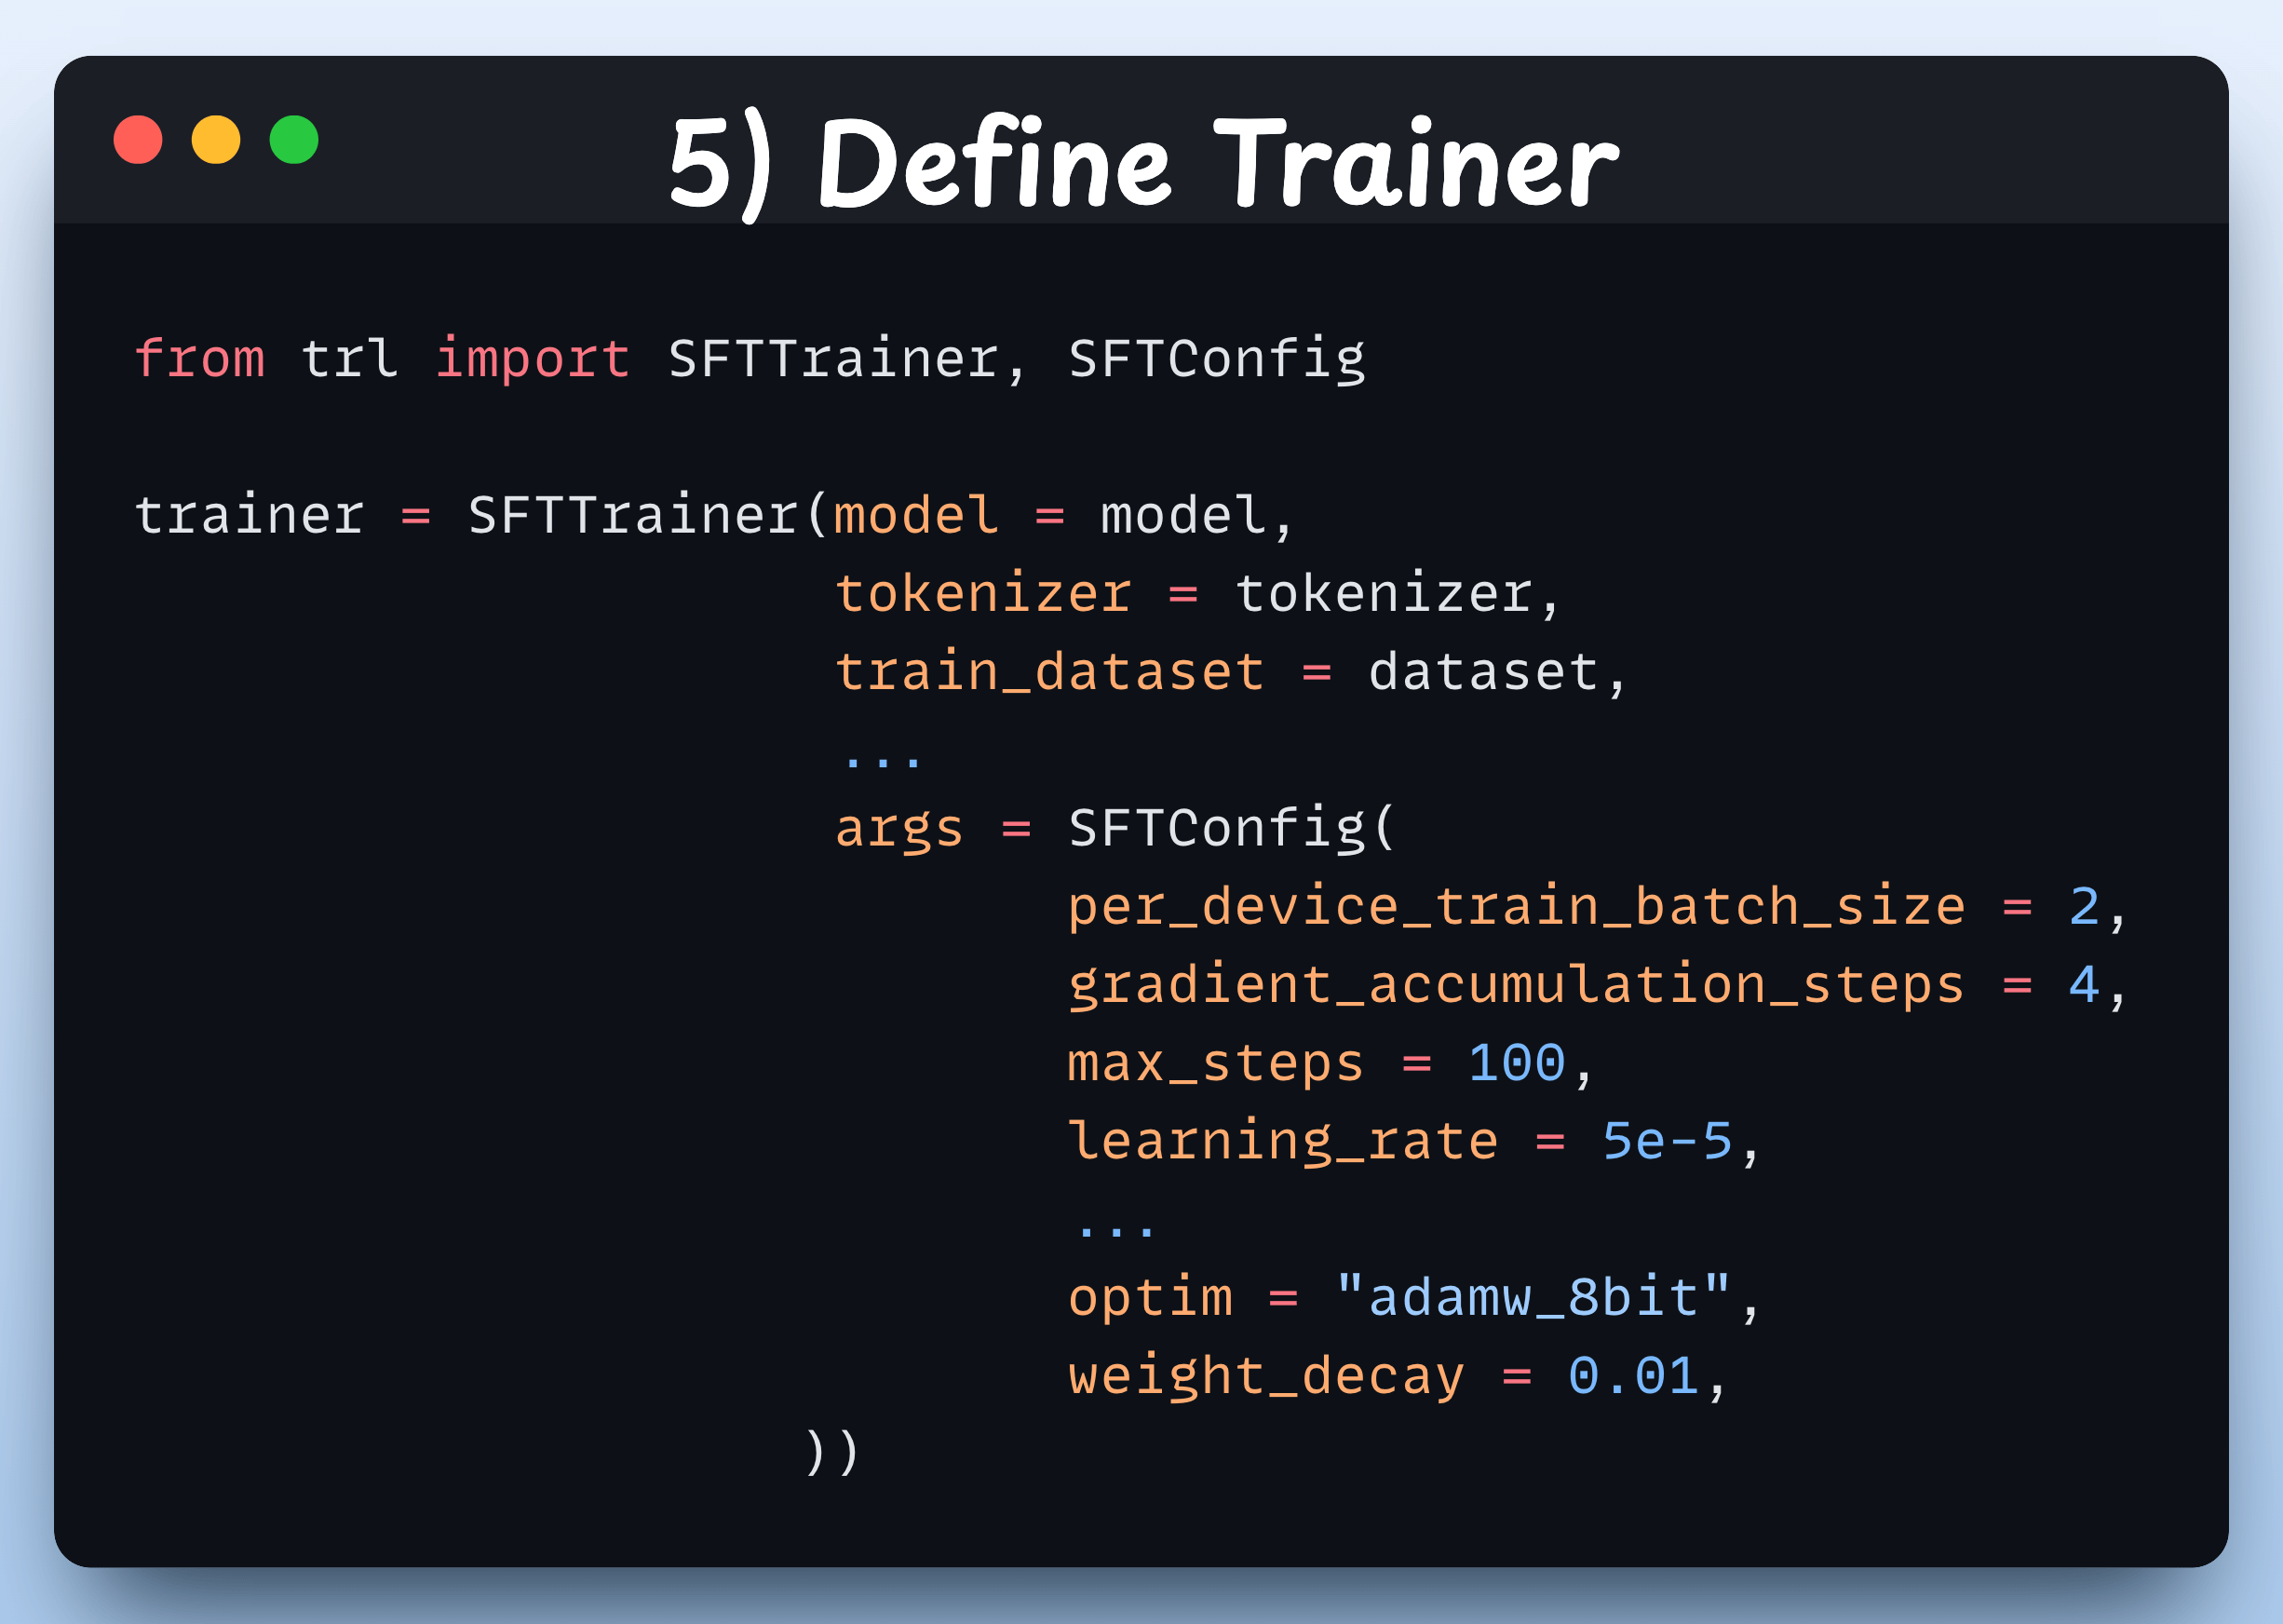

In [10]:
from til import SFTTrainer, SFTConfig

trainer = SFTTrainer (model = model,
  tokenizer = tokenizer,
  train_dataset = dataset,
  #...
  args = SFTConfig(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    max_steps = 100,
    learning_rate = 5e-5,
    #...
    optim = "adamw_8bit",
    weight_decay = 0.01,
))

ModuleNotFoundError: No module named 'til'

In [ ]:
trainer_stats = trainer.train()